#  **TAAK HAC - CUDA**

*Indy Penders - Samir Machkour - Miguel Nunez - Jelle*

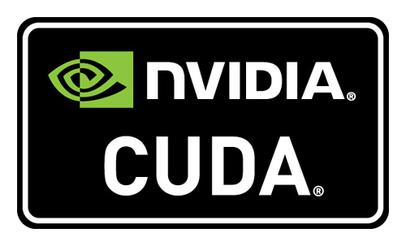


*   Een CUDA C applicatie die 2D convolutie uitrekend op basis van een 3x3 matrix. De kolomwaarden zijn respectievelijk 1, 0 en  -1.  

*   De applicatie voert de verschillende functies uit op zowel de GPU als de CPU om de snelheid te vergelijken.



- - - - - - - - 

- - - - - - - - 


# **VOORBEREIDEN NOTEBOOK**

## AANMAKEN FOLDERS

Maakt 4 folders aan, 1 voor de input bestanden en 3 voor de output bestanden per type process.

In [1]:
!mkdir convImg
!mkdir minImg
!mkdir maxImg
!mkdir inputImg

## FETCH LIBRARY STD_IMAGE

Download stb library.


In [2]:
!wget https://raw.githubusercontent.com/nothings/stb/master/stb_image.h
!wget https://raw.githubusercontent.com/nothings/stb/master/stb_image_write.h

--2023-01-07 19:29:12--  https://raw.githubusercontent.com/nothings/stb/master/stb_image.h
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 279339 (273K) [text/plain]
Saving to: ‘stb_image.h’

stb_image.h         100%[===================>] 272.79K  --.-KB/s    in 0.01s   

2023-01-07 19:29:13 (22.3 MB/s) - ‘stb_image.h’ saved [279339/279339]

--2023-01-07 19:29:13--  https://raw.githubusercontent.com/nothings/stb/master/stb_image_write.h
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71221 (70K) [text/plain]
Saving to: ‘stb_image_

## DOWNLOAD INPUT BESTANDEN

Slaat 10 foto's, genummerd van 0 tot 9, op in de folder *inputImg*

In [3]:
!wget -P /content/inputImg/ https://raw.githubusercontent.com/JelleClaes2/picturesHAC/main/foto0.png
!wget -P /content/inputImg/ https://raw.githubusercontent.com/JelleClaes2/picturesHAC/main/foto1.png
!wget -P /content/inputImg/ https://raw.githubusercontent.com/JelleClaes2/picturesHAC/main/foto2.png
!wget -P /content/inputImg/ https://raw.githubusercontent.com/JelleClaes2/picturesHAC/main/foto3.png
!wget -P /content/inputImg/ https://raw.githubusercontent.com/JelleClaes2/picturesHAC/main/foto4.png
!wget -P /content/inputImg/ https://raw.githubusercontent.com/JelleClaes2/picturesHAC/main/foto5.png
!wget -P /content/inputImg/ https://raw.githubusercontent.com/JelleClaes2/picturesHAC/main/foto6.png
!wget -P /content/inputImg/ https://raw.githubusercontent.com/JelleClaes2/picturesHAC/main/foto7.png
!wget -P /content/inputImg/ https://raw.githubusercontent.com/JelleClaes2/picturesHAC/main/foto8.png
!wget -P /content/inputImg/ https://raw.githubusercontent.com/JelleClaes2/picturesHAC/main/foto9.png

--2023-01-07 19:29:16--  https://raw.githubusercontent.com/JelleClaes2/picturesHAC/main/foto0.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121028 (118K) [image/png]
Saving to: ‘/content/inputImg/foto0.png’

foto0.png           100%[===================>] 118.19K  --.-KB/s    in 0.007s  

2023-01-07 19:29:16 (16.1 MB/s) - ‘/content/inputImg/foto0.png’ saved [121028/121028]

--2023-01-07 19:29:17--  https://raw.githubusercontent.com/JelleClaes2/picturesHAC/main/foto1.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35855 (3

## CLONE STB.GIT

In [4]:
!git clone https://github.com/nothings/stb.git

Cloning into 'stb'...
remote: Enumerating objects: 7851, done.
remote: Total 7851 (delta 0), reused 0 (delta 0), pack-reused 7851
Receiving objects: 100% (7851/7851), 5.34 MiB | 17.40 MiB/s, done.
Resolving deltas: 100% (5213/5213), done.


## FILE AANMAAK

Schrijft een file met de verschillende functies voor de opdracht;

*   Min pooling op GPU & CPU
*   Max pooling op GPU & CPU
*   2D convolutie op GPU & CPU
*   Berekenen process tijd
*   Analyse


In [5]:
%%writefile HAC_eindopdracht.cu
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <time.h>
#include "cuda.h"
#include "cuda_runtime.h"
#define STB_IMAGE_IMPLEMENTATION
#define STB_IMAGE_WRITE_IMPLEMENTATION
#include "stb_image.h"
#include "stb_image_write.h"

// Struct to hold the image data
struct Pixel
{
	unsigned char r, g, b, a;
};

//**********************************************************************************************************************
//*************************************** CPU FUNCTIONS ****************************************************************
//**********************************************************************************************************************

// *********************************************
// **** CONVOLUTION CPU (built in grayscale)****
// *********************************************
void imageConvolutionCpu(unsigned char *inputImage, unsigned char *outputImage, int width, int height, int16_t *kernel)
{
    // Grayscale the input image
    for (int h = 0; h < height; h++)
    {
        for (int w = 0; w < width; w++)
        {
            // Load the pixel
            Pixel *ptrInputPix = (Pixel *)&inputImage[(w * 4) + (h * width * 4)];
            // Calculate the grayscale value
            int grayscale = (0.2989 * ptrInputPix->r) + (0.5870 * ptrInputPix->g) + (0.1140 * ptrInputPix->b);
            // Set the pixel values to the grayscale value
            ptrInputPix->r = grayscale;
            ptrInputPix->g = grayscale;
            ptrInputPix->b = grayscale;
        }
    }

    // Iterate over the 3x3 blocks of the input image
    for (int x = 0; x < height - 2; x++)
    {
        for (int y = 0; y < width - 2; y++)
        {
            // Output pixel
            Pixel *ptrOutputPix = (Pixel *)&outputImage[(y * 4) + (x * (width - 2) * 4)];

            // Initialize the convolved values for each channel to 0
            int ConValueR = 0;
            int ConValueG = 0;
            int ConValueB = 0;

            // Iterate over the kernel values
            for (int kx = 0; kx < 3; kx++)
            {
                for (int ky = 0; ky < 3; ky++)
                {
                    // Load the pixel
                    Pixel *ptrInputPix = (Pixel *)&inputImage[(y * 4) + (ky * 4) + (width * kx * 4) + (x * width * 4)];
                    // Multiply the pixel value by the corresponding kernel value and add it to the convolved value
                    ConValueR += ptrInputPix->r * kernel[ky + kx * 3];
                    ConValueG += ptrInputPix->g * kernel[ky + kx * 3];
                    ConValueB += ptrInputPix->b * kernel[ky + kx * 3];
                }
            }

            // Clamp the convolved values to the range 0-255
            ptrOutputPix->r = ConValueR < 0 ? 0 : (ConValueR > 255 ? 255 : ConValueR);
            ptrOutputPix->g = ConValueG < 0 ? 0 : (ConValueG > 255 ? 255 : ConValueG);
            ptrOutputPix->b = ConValueB < 0 ? 0 : (ConValueB > 255 ? 255 : ConValueB);
            ptrOutputPix->a = 255;
        }
    }
}

// *************************
// **** MIN POOLING CPU ****
// *************************
void minPoolingCpu(unsigned char *imageRGBA, unsigned char *output, int width, int height)
{
    for (int y = 0; y < height; y += 2)
    {
        for (int x = 0; x < width; x += 2)
        {
            int minR = 255;
            int minG = 255;
            int minB = 255;
           

            for (int yy = 0; yy < 2; yy++)
            {
                for (int xx = 0; xx < 2; xx++)
                {
                    // Get the pixel data
                    int index = (x * 4) + (xx * 4) + (y * width * 4) + (yy * width * 4);
                    Pixel *ptrInputPix = (Pixel *)&imageRGBA[index];
                    // Update the minumum values
                    if (ptrInputPix->r < minR)
                        minR = ptrInputPix->r;
                    if (ptrInputPix->g < minG)
                        minG = ptrInputPix->g;
                    if (ptrInputPix->b < minB)
                        minB = ptrInputPix->b;
                    
                }
            }

            // Get the output pixel
            Pixel *ptrOutputPix = (Pixel *)&output[(x / 2 * 4) + (y / 2 * width / 2 * 4)];
            // Set the values based on the selected operation
            ptrOutputPix->r = minR;
            ptrOutputPix->g = minG;
            ptrOutputPix->b = minB;
            ptrOutputPix->a = 255;
        }
    }
}
// *************************
// **** MAX POOLING CPU ****
// *************************
void maxPoolingCpu(unsigned char *imageRGBA, unsigned char *output, int width, int height)
{
    for (int y = 0; y < height; y += 2) // Iterate over height
    {
        for (int x = 0; x < width; x += 2) // Iterate over width
        {
            int maxR = 0;
            int maxG = 0;
            int maxB = 0;
            for (int yy = 0; yy < 2; yy++)
            {
                for (int xx = 0; xx < 2; xx++)
                {
                    // Get the pixel data
                    int index = (x * 4) + (xx * 4) + (y * width * 4) + (yy * width * 4);
                    Pixel *ptrInputPix = (Pixel *)&imageRGBA[index];
                   
                    // Update the maximum values
                    if (ptrInputPix->r > maxR)
                        maxR = ptrInputPix->r;
                    if (ptrInputPix->g > maxG)
                        maxG = ptrInputPix->g;
                    if (ptrInputPix->b > maxB)
                        maxB = ptrInputPix->b;
                }
            }

            // Get the output pixel
            Pixel *ptrOutputPix = (Pixel *)&output[(x / 2 * 4) + (y / 2 * width / 2 * 4)];
            // Set the values based on the selected operation
            ptrOutputPix->r = maxR;
            ptrOutputPix->g = maxG;
            ptrOutputPix->b = maxB;
            ptrOutputPix->a = 255;
        }
    }
}

//**********************************************************************************************************************
//*************************************** GPU FUNCTIONS ****************************************************************
//**********************************************************************************************************************

// *********************
// **** MIN POOLING ****
// *********************
__global__ void minPoolingGpu(unsigned char* imageRGBA, unsigned char* output, size_t stride, int width, int height)
{
	int index = (blockDim.x * blockIdx.x + threadIdx.x);
	for (int x = 0; x < (height / 2); x++) // itterate height
	{
		for (int y = index; y < (width / 2); y += stride) // itterate width
		{
			// read pixel values
			Pixel* pix1 = (Pixel *) &imageRGBA[(y * 2 * 4) + (0 * 4) + (width * 0 * 4) + (x * 2 * width * 4)];
			Pixel* pix2 = (Pixel *) &imageRGBA[(y * 2 * 4) + (1 * 4) + (width * 0 * 4) + (x * 2 * width * 4)];

			Pixel* pix3 = (Pixel *) &imageRGBA[(y * 2 * 4) + (0 * 4) + (width * 1 * 4) + (x * 2 * width * 4)];
			Pixel* pix4 = (Pixel *) &imageRGBA[(y * 2 * 4) + (1 * 4) + (width * 1 * 4) + (x * 2 * width * 4)];

			// output pixel
			Pixel* ptrOutputPix = (Pixel *) &output[(y * 4) + (x * (width / 2) * 4)];
			// store value for output
			int tempPix;
            // RED channel
            tempPix = min(pix1->r, pix2->r); 
            tempPix = min(tempPix, pix3->r);
            tempPix = min(tempPix, pix4->r);
            ptrOutputPix->r = tempPix; 
            // GREEN channel
            tempPix = min(pix1->g, pix2->g); 
            tempPix = min(tempPix, pix3->g);
            tempPix = min(tempPix, pix4->g);
            ptrOutputPix->g = tempPix; 
            // BLUE channel
            tempPix = min(pix1->b, pix2->b); 
            tempPix = min(tempPix, pix3->b);
            tempPix = min(tempPix, pix4->b);
            ptrOutputPix->b = tempPix; 
            // ALPHA channel (transparantie)
            ptrOutputPix->a = 255; 
		}
	}
}

// *********************
// **** MAX POOLING ****
// *********************
__global__ void maxPoolingGpu(unsigned char* imageRGBA, unsigned char* output, size_t stride, int width, int height)
{
	int index = (blockDim.x * blockIdx.x + threadIdx.x);
	for (int x = 0; x < (height / 2); x++) // itterate height
	{
		for (int y = index; y < (width / 2); y += stride) // itterate width
		{
			// read pixel values
			Pixel* pix1 = (Pixel *) &imageRGBA[(y * 2 * 4) + (0 * 4) + (width * 0 * 4) + (x * 2 * width * 4)];
			Pixel* pix2 = (Pixel *) &imageRGBA[(y * 2 * 4) + (1 * 4) + (width * 0 * 4) + (x * 2 * width * 4)];

			Pixel* pix3 = (Pixel *) &imageRGBA[(y * 2 * 4) + (0 * 4) + (width * 1 * 4) + (x * 2 * width * 4)];
			Pixel* pix4 = (Pixel *) &imageRGBA[(y * 2 * 4) + (1 * 4) + (width * 1 * 4) + (x * 2 * width * 4)];

			// output pixel
			Pixel* ptrOutputPix = (Pixel *) &output[(y * 4) + (x * (width / 2) * 4)];
			// store value for output
			int tempPix;
            // RED channel
            tempPix = max(pix1->r, pix2->r);
            tempPix = max(tempPix, pix3->r);
            tempPix = max(tempPix, pix4->r);
           
            ptrOutputPix->r = tempPix;
            // GREEN channel
            tempPix = max(pix1->g, pix2->g);
            tempPix = max(tempPix, pix3->g);
            tempPix = max(tempPix, pix4->g);
            
            ptrOutputPix->g = tempPix;
            // BLUE channel
            tempPix = max(pix1->b, pix2->b);
            tempPix = max(tempPix, pix3->b);
            tempPix = max(tempPix, pix4->b);
            
            ptrOutputPix->b = tempPix;
            // ALPHA channel (transparantie)
            ptrOutputPix->a = 255;

		}
	}
}

// *********************
// ***** GRAYSCALE *****
// *********************
__global__ void ConvertImageToGrayGpu(unsigned char* imageRGBA, size_t pixels, size_t stride, int width)
{
	int index = (blockDim.x * blockIdx.x + threadIdx.x) * 4; 
	for (int i = index; i < pixels; i += stride)
    {
		Pixel* ptrPixel = (Pixel*)&imageRGBA[i]; 
		unsigned char pixelValue = (unsigned char)(ptrPixel->r * 0.2126f + ptrPixel->g * 0.7152f + ptrPixel->b * 0.0722f); 
		ptrPixel->r = pixelValue; // Store the data directly into the input image
		ptrPixel->g = pixelValue;
		ptrPixel->b = pixelValue;
		ptrPixel->a = 255;
    }
}

// *********************
// **** CONVOLUTION ****
// *********************
__global__ void imageConvolutionGpu(unsigned char* inputImage, unsigned char* outputImage, size_t stride, int width, int height, int16_t * kernel)
{
	int index = (blockDim.x * blockIdx.x + threadIdx.x);
	for (int x = 0; x < (height - 2); x++) // itterate height
	{
		for (int y = index; y < (width - 2); y += stride) // itterate width
		{
			// Iterate over the 3x3 blocks of the input image
            // Output pixel
            Pixel *ptrOutputPix = (Pixel *)&outputImage[(y * 4) + (x * (width - 2) * 4)];

            // Initialize the convolved values for each channel to 0
            int ConValueR = 0;
            int ConValueG = 0;
            int ConValueB = 0;

            // Iterate over the kernel values
            for (int kx = 0; kx < 3; kx++)
            {
                for (int ky = 0; ky < 3; ky++)
                {
                    // Load the pixel
                    Pixel *ptrInputPix = (Pixel *)&inputImage[(y * 4) + (ky * 4) + (width * kx * 4) + (x * width * 4)];
                    // Multiply the pixel value by the corresponding kernel value and add it to the convolved value
                    ConValueR += ptrInputPix->r * kernel[ky + kx * 3];
                    ConValueG += ptrInputPix->g * kernel[ky + kx * 3];
                    ConValueB += ptrInputPix->b * kernel[ky + kx * 3];
                }
            }

            // Clamp the convolved values to the range 0-255
            ptrOutputPix->r = ConValueR < 0 ? 0 : (ConValueR > 255 ? 255 : ConValueR);
            ptrOutputPix->g = ConValueG < 0 ? 0 : (ConValueG > 255 ? 255 : ConValueG);
            ptrOutputPix->b = ConValueB < 0 ? 0 : (ConValueB > 255 ? 255 : ConValueB);
            ptrOutputPix->a = 255;
        }
    }
}

// **********************
// **** MAIN PROGRAM ****
// **********************
int main(int argc, char** argv)
{
    // 3x3 KERNEL matrix
	int16_t kernel[9] = 
	{
		1, 0, -1,
		1, 0, -1,
		1, 0, -1
	};
    
    // Preproces gpu
	char fileName[32];
	unsigned char *inputArr[10]; // input image data
	unsigned char *outputArr[3][10]; // output image data
    int componentCount;
	int width[10];
	int height[10];

  cudaEvent_t start, stop;
	cudaEventCreate(&start);
	cudaEventCreate(&stop);
	float GpuTimer; 

    printf("********************************\r\n");
    printf("** CONVOLUTION & POOLING TOOL **\r\n");
    printf("********************************\r\n\r\n");

	  printf("Reading images...\r\n");

	for (int i = 0; i < 10; i++) // Load all 10 images
	{
		memset(fileName, '\0', 32);
		char folder_path_input[100] = "/content/inputImg/";
		sprintf(fileName, "%sfoto%i.png", folder_path_input, i); 
		printf("Reading: %s\r\n", fileName);

		inputArr[i] = stbi_load(fileName, &width[i], &height[i], &componentCount, 4);
		if (!inputArr[i])
            printf("failed to open image %i\r\n", i+(i*(-2)));

        // min pool
		outputArr[0][i] = (unsigned char *) malloc((width[i] / 2) * (height[i] / 2) * 4);
        // max pool
		outputArr[1][i] = (unsigned char *) malloc((width[i] / 2) * (height[i] / 2) * 4);
        // convolution
		outputArr[2][i] = (unsigned char *) malloc((width[i] - 2) * (height[i] - 2) * 4); 
	}

    // GPU
	int device;
	cudaGetDevice(&device);
	cudaDeviceProp properties;
	cudaGetDeviceProperties(&properties, device);

	size_t RGBA[10]; 
	size_t threads_per_block[10];
	size_t number_of_blocks[10];
	size_t stride[10];

	int16_t *ptrKernel = nullptr;
	unsigned char *ptrInputImg[10];
	unsigned char *ptrOutputImg[3][10]; // min, avr, max and con

	for (int i = 0; i < 10; i++)
	{
		RGBA[i] = width[i] * height[i] * 4;
		threads_per_block[i] = min(properties.maxThreadsPerMultiProcessor, width[i]); 
		number_of_blocks[i] = (RGBA[i] + threads_per_block[i] - 1) / threads_per_block[i];
		stride[i] = threads_per_block[i] * number_of_blocks[i];
	}

	cudaEventRecord(start); 

	// Kernel alloc
	cudaMalloc(&ptrKernel, 9 * sizeof(int16_t)); 
	cudaMemcpy(ptrKernel, kernel, 9 * sizeof(int16_t), cudaMemcpyHostToDevice);

    // Host 2 Device
	for (int i = 0; i < 10; i++)
	{
		ptrInputImg[i] = nullptr;
		ptrOutputImg[0][i] = nullptr;
		ptrOutputImg[1][i] = nullptr;
		ptrOutputImg[2][i] = nullptr;

		cudaMalloc(&ptrInputImg[i], width[i] * height[i] * 4);
		cudaMalloc(&ptrOutputImg[0][i], (width[i] / 2) * (height[i] / 2) * 4);
		cudaMalloc(&ptrOutputImg[1][i], (width[i] / 2) * (height[i] / 2) * 4);
		cudaMalloc(&ptrOutputImg[2][i], (width[i] - 2) * (height[i] - 2) * 4);

		cudaMemcpy(ptrInputImg[i], inputArr[i], width[i] * height[i] * 4, cudaMemcpyHostToDevice);
		cudaMemcpy(ptrOutputImg[0][i], outputArr[0][i], (width[i] / 2) * (height[i] / 2) * 4, cudaMemcpyHostToDevice);
		cudaMemcpy(ptrOutputImg[1][i], outputArr[1][i], (width[i] / 2) * (height[i] / 2) * 4, cudaMemcpyHostToDevice);
		cudaMemcpy(ptrOutputImg[2][i], outputArr[2][i], (width[i] - 2) * (height[i] - 2) * 4, cudaMemcpyHostToDevice);
	}
	cudaDeviceSynchronize();

	// min pool
	for (int i = 0; i < 10; i++)
	{
		cudaStream_t stream;
		cudaStreamCreate(&stream);
		minPoolingGpu<<<number_of_blocks[i],threads_per_block[i], 0, stream>>>(ptrInputImg[i], ptrOutputImg[0][i], stride[i], width[i], height[i]);
		cudaStreamDestroy(stream);
	}

	// max pool
	for (int i = 0; i < 10; i++)
	{
		cudaStream_t stream;
		cudaStreamCreate(&stream);
		maxPoolingGpu<<<number_of_blocks[i],threads_per_block[i], 0, stream>>>(ptrInputImg[i], ptrOutputImg[1][i], stride[i], width[i], height[i]);
		cudaStreamDestroy(stream);
	}
	cudaDeviceSynchronize(); 

	// Preprocess Convovlution
	for (int i = 0; i < 10; i++)
	{
		cudaStream_t stream;
		cudaStreamCreate(&stream);
		ConvertImageToGrayGpu<<<number_of_blocks[i],threads_per_block[i], 0, stream>>>(ptrInputImg[i], RGBA[i], stride[i], width[i]);
		cudaStreamDestroy(stream);
	}
	cudaDeviceSynchronize(); 

	// Convolution
	for (int i = 0; i < 10; i++)
	{
		cudaStream_t stream;
		cudaStreamCreate(&stream);
		imageConvolutionGpu<<<number_of_blocks[i],threads_per_block[i], 0, stream>>>(ptrInputImg[i], ptrOutputImg[2][i], stride[i], width[i], height[i], ptrKernel);
		cudaStreamDestroy(stream);
	}
	cudaDeviceSynchronize(); 

	// Device 2 Host
	for (int i = 0; i < 10; i++)
	{
		cudaMemcpy(outputArr[0][i], ptrOutputImg[0][i], (width[i] / 2) * (height[i] / 2) * 4, cudaMemcpyDeviceToHost);
		cudaMemcpy(outputArr[1][i], ptrOutputImg[1][i], (width[i] / 2) * (height[i] / 2) * 4, cudaMemcpyDeviceToHost);
		cudaMemcpy(outputArr[2][i], ptrOutputImg[2][i], (width[i] - 2) * (height[i] - 2) * 4, cudaMemcpyDeviceToHost);
	}
	cudaDeviceSynchronize(); 

	cudaEventRecord(stop); 
	cudaEventSynchronize(stop);
	GpuTimer = 0;
	cudaEventElapsedTime(&GpuTimer, start, stop);

	printf("Writing files GPU...\r\n");
	for (int i = 0; i < 10; i++)
	{
		memset(fileName, '\0', 16);
		sprintf(fileName, "/content/minImg/min_%i.png", i); 
		stbi_write_png(fileName, width[i] / 2, height[i] / 2, 4, outputArr[0][i], 4 * (width[i] / 2));

		memset(fileName, '\0', 16);
		sprintf(fileName, "/content/maxImg/max_%i.png", i);
		stbi_write_png(fileName, width[i] / 2, height[i] / 2, 4, outputArr[1][i], 4 * (width[i] / 2));

		memset(fileName, '\0', 16);
		sprintf(fileName, "/content/convImg/con_%i.png", i);
		stbi_write_png(fileName, width[i] - 2, height[i] - 2, 4, outputArr[2][i], 4 * (width[i] - 2));
	}

    // free memory
	cudaFree(ptrKernel);
	for (int i = 0; i < 10; i++)
	{
		cudaFree(ptrInputImg[i]);
		cudaFree(ptrOutputImg[0][i]);
		cudaFree(ptrOutputImg[1][i]);
		cudaFree(ptrOutputImg[2][i]);
		stbi_image_free(inputArr[i]);
		free(outputArr[0][i]);
		free(outputArr[1][i]);
		free(outputArr[2][i]);
	}

	printf("Finished process on the GPU.\r\n");

	printf("Process time on GPU: %3.9f ms\r\n\n", GpuTimer);

// **********************************************************************************************************************************
    //CPU section start
    // All the data CPU
    char imageFileIn[64];
    unsigned char *inputArrCpu[10];      // There are 10 images to process
    unsigned char *outputArrCpu[3][10]; // min, max and con

    // Timing
    clock_t start1 = clock();
    printf("************************************\r\n");
    printf("** CONVOLUTION & POOLING TOOL CPU **\r\n");
    printf("************************************\r\n\r\n");

	  printf("Reading images...\r\n");

// Loading data
    for (int i = 0; i < 10; i++) // Load all 10 images
    {
        memset(imageFileIn, '\0', 32);
        char folder_path_input[100] = "/content/inputImg/";
        sprintf(imageFileIn, "%sfoto%i.png", folder_path_input, i); 
        printf("Reading: %s\r\n", imageFileIn);

        inputArrCpu[i] = stbi_load(imageFileIn, &width[i], &height[i], &componentCount, 4);
        if (!inputArrCpu[i])
            return (0 - (i + 1));
        // Min pool
        outputArrCpu[0][i] = (unsigned char *)malloc((width[i] / 2) * (height[i] / 2) * 4); 
        // Max Pool
        outputArrCpu[1][i] = (unsigned char *)malloc((width[i] / 2) * (height[i] / 2) * 4); 
        // Convolution
        outputArrCpu[2][i] = (unsigned char *)malloc((width[i] - 2) * (height[i] - 2) * 4); 
    }

    // Performing the image processing functions on the CPU
    // Loop through all 10 images
    for (int i = 0; i < 10; i++) 
    {
        minPoolingCpu(inputArrCpu[i], outputArrCpu[0][i], width[i], height[i]);
        maxPoolingCpu(inputArrCpu[i], outputArrCpu[1][i], width[i], height[i]);
        imageConvolutionCpu(inputArrCpu[i], outputArrCpu[2][i], width[i], height[i], kernel);
    }

    // Saving all the resulting images (cpu named)
	printf("Writing files CPU...\r\n");
    for (int i = 0; i < 10; i++) 
    {
        char imageFileOut[32];
        memset(imageFileOut, '\0', 32);
        char folder_path_output_min[100] = "/content/minImg/";
        sprintf(imageFileOut, "%sfoto%i_min_cpu.png", folder_path_output_min, i);               
        stbi_write_png(imageFileOut, width[i] / 2, height[i] / 2, 4, outputArrCpu[0][i], 0); 

        memset(imageFileOut, '\0', 32);
        char folder_path_output_max[100] = "/content/maxImg/";
        sprintf(imageFileOut, "%sfoto%i_max_cpu.png", folder_path_output_max, i);               
        stbi_write_png(imageFileOut, width[i] / 2, height[i] / 2, 4, outputArrCpu[1][i], 0); 

        memset(imageFileOut, '\0', 32);
        char folder_path_output_conv[100] = "/content/convImg/";
        sprintf(imageFileOut, "%sfoto%i_con_cpu.png", folder_path_output_conv, i);              
        stbi_write_png(imageFileOut, width[i] - 2, height[i] - 2, 4, outputArrCpu[2][i], 0); 
    }

        // End clock function
     clock_t stop1 = clock();
     double elapsedCpu = (double)(stop1 - start1) / CLOCKS_PER_SEC;
     double elapsed_msCpu = elapsedCpu * 1000;

    // Free data
    for (int i = 0; i < 10; i++)
    {
        stbi_image_free(inputArrCpu[i]);
        free(outputArrCpu[0][i]); //min
        free(outputArrCpu[1][i]); //max
        free(outputArrCpu[2][i]); //conv
    }
	  printf("Finished process on the CPU.\r\n");
    printf("Process time on CPU: %3.9f ms\r\n ", elapsed_msCpu);
	return 0;
}
     

     

Writing HAC_eindopdracht.cu


## COMPILEER FILE

Compileer de file voor de GPU

In [6]:
!nvcc HAC_eindopdracht.cu -o run

stb_image.h(4207): warning: variable "old_limit" was set but never used

stb_image.h(5121): warning: variable "idata_limit_old" was set but never used

stb_image.h(6894): warning: variable "out_size" was set but never used

stb_image.h(6895): warning: variable "delays_size" was set but never used



# **UITVOEREN CODE**

voert de gecompileerde code uit.

In [7]:
!./run

********************************
** CONVOLUTION & POOLING TOOL **
********************************

Reading images...
Reading: /content/inputImg/foto0.png
Reading: /content/inputImg/foto1.png
Reading: /content/inputImg/foto2.png
Reading: /content/inputImg/foto3.png
Reading: /content/inputImg/foto4.png
Reading: /content/inputImg/foto5.png
Reading: /content/inputImg/foto6.png
Reading: /content/inputImg/foto7.png
Reading: /content/inputImg/foto8.png
Reading: /content/inputImg/foto9.png
Writing files GPU...
Finished process on the GPU.
Process time on GPU: 11.741855621 ms

************************************
** CONVOLUTION & POOLING TOOL CPU **
************************************

Reading images...
Reading: /content/inputImg/foto0.png
Reading: /content/inputImg/foto1.png
Reading: /content/inputImg/foto2.png
Reading: /content/inputImg/foto3.png
Reading: /content/inputImg/foto4.png
Reading: /content/inputImg/foto5.png
Reading: /content/inputImg/foto6.png
Reading: /content/inputImg/foto7.pn

## ZIP de notebook met alle resultaten

Nadat de zip aangemaakt is, kan deze gedownload worden naar uw persoonlijke HDD.

In [ ]:
!zip -r /content/HacFinal.zip /content/